In [22]:
import numpy as np
import torch
import scipy
import time

import sys
sys.path.insert(1, './PSM_V1')
from sobolev import Sobolev
from solver import Solver
from utils import matmul
from diffeomorphisms import hyper_rect
import surrogates
import matplotlib.pyplot as plt
from pinnutils import PINN
#from pinnutils import PINNN

In [3]:
device = torch.device('cpu' if torch.cuda.is_available() else 'cpu')
torch.set_default_dtype(torch.float32)

In [4]:
# Tests
# a=-1.0, b=1.0, q=3, sob_2d(deg=30), sob_1d(deg=100), model(n=30, p=np.inf), s=[0,-1], optimizer:LBFGS

### 2D Poisson Equation
Let $\Omega = (-1 , 1)^2, A, C, \omega, \beta \in \mathbb{R}$:
$${\large\begin{cases}
        \partial_x^2 u + f = 0, (x,y) \in \Omega\\
        u = g, (x,y) \in \partial \Omega
    \end{cases}}$$
with:
$$
    f(x):= C\big(A\omega^2 \sin(\omega x)+2\beta^2\mathrm{sech}^2(x)\textrm{tanh}(\beta x)\big)
$$
$$
    g(x):= C(A\sin(\omega x)+\tanh(\beta x))$$

In [5]:
rect = np.array([[-1.0, 1.0]])

q = 3
lam = 2*np.pi*q

def f(x,y):
    return 2*lam**2*np.cos(lam*x)*np.sin(lam*y)

In [6]:
# Sobolev Cubature
diffeo_1d = hyper_rect(rect[0])

sob_1d = Sobolev(deg=200, diffeo=diffeo_1d)

dx2= torch.tensor(sob_1d.diff.diffs(np.array([[2]])), dtype = torch.float32)

### Ground Truth

In [7]:

#Define ground truth
omega = 20*np.pi
A = 0.1
beta = 30
amp = 0.1
def gt(x):
    return amp*(A*torch.sin(omega*x)+torch.tanh(beta*x))
#RHS
def f(x):
    return amp*(A*omega**2*torch.sin(omega*x) + 
         (2*beta**2)*(1/torch.cosh(beta*x)**2)*torch.tanh(beta*x))

### Gradient Flow

In [8]:
# |--------------------------------------------|
# |  Operator  |          Formulation          |  
# |------------|-------------------------------|
# | id         |  L2 grad of L2                | 
# | m_inv      |  L2 grad of Sob               |
# | weak m_inv |  L2 grad of weak Sob          |
# | m          |  L2 grad of negative Sob      |
# | weak m     |  L2 grad of weak negative Sob |
# |--------------------------------------------|
#
# For that use:
# -> sob.set_s(s)
# -> sob.metric(rev=False/True, weak=False/True)

In [9]:
# Sobolev Order
sob_1d.set_s(0)

In [10]:
# Data
_, xs = sob_1d.get_xs()

Xt = torch.tensor(xs[0], dtype = torch.float32, requires_grad = True).reshape(-1,1)
Xl = torch.tensor([-1],  dtype = torch.float32, requires_grad = True)
Xr = torch.tensor([1],  dtype = torch.float32,  requires_grad = True)

u_bdl = torch.tensor(gt(Xl), dtype = torch.float32)
u_bdr = torch.tensor(gt(Xr), dtype = torch.float32)
w_1d = torch.tensor(sob_1d.get_leja_weights(), dtype = torch.float32)
X_m =  torch.tensor(xs[0], dtype = torch.float32).reshape(-1,1)
fXY = f(X_m).T[0]

/tmp/ipykernel_140769/1748268450.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  u_bdl = torch.tensor(gt(Xl), dtype = torch.float32)
/tmp/ipykernel_140769/1748268450.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  u_bdr = torch.tensor(gt(Xr), dtype = torch.float32)
/tmp/ipykernel_140769/1748268450.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  w_1d = torch.tensor(sob_1d.get_leja_weights(), dtype = torch.float32)


In [11]:
#Sobolev Metrics
metric_1d = sob_1d.l2_metric()

# Formulation
K = dx2[0]
eq = lambda u: matmul(K, u)+fXY
crit_pde = lambda u: sob_2d.loss(eq(u), weak=True)
#grad_dmn = lambda u: 2*matmul(K.T, metric_2d(eq(u)))
#grad_bndr_0 = lambda u: 2*metric_1d_0(u-u_bndr_0)
#grad_bndr_1 = lambda u: 2*metric_1d_1(u-u_bndr_1)

In [12]:
TD = np.concatenate([X_m.detach().numpy()], 0)
# compute mean and std of training data
X_mean = torch.tensor(np.mean(TD, axis=0, keepdims=True),device=device)
X_std = torch.tensor(np.std(TD, axis=0, keepdims=True),device=device)
seedc = 1

In [13]:
import torch.nn as nn

from torch.autograd import grad
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.optim.lr_scheduler import ExponentialLR

from scipy.interpolate import griddata
from itertools import product, combinations

from torch.optim.lr_scheduler import ExponentialLR, MultiStepLR
from tqdm import tqdm_notebook as tqdm 
class sine(nn.Module):
    def forward(self,x):
        return torch.sin(x)


In [14]:
def closure(optim):
        optim.zero_grad()
        loss.backward()
        return loss

In [15]:
lam_s = torch.max(torch.linalg.eig(dx2)[0].real)

In [19]:
net = PINN(sizes=[1,50,50,50,50,1], mean=X_mean, std=X_std, seed=seedc, activation=sine()).to(device)
print("#parameters:", sum(p.numel() for p in net.parameters() if p.requires_grad))
n_epochs   = 30000
lamb  = 1
losses_bc  = [];
losses_reg = [];
params = [{'params': net.parameters()}]
milestones = [[15000,25000]]
optimizer = torch.optim.Adam(params)
scheduler = MultiStepLR(optimizer, milestones[0], gamma=0.1)
start_time = time.time()
ds = 1
for epoch in range(n_epochs):
    
    optimizer.zero_grad()
    uhat  = net(Xt).T[0]
    #l_pde   = crit_pde(uhat)
    l_pde = torch.sum(((eq(uhat)*w_1d)**2))
    predxl = net(Xl).T[0]
    predxr = net(Xr).T[0]
    #l_bc = crit_bdxl(predxl) + crit_bdxr(predxr) + crit_bdyl(predyl) + crit_bdyr(predyr) 
    l_bc = (predxl-u_bdl)**2+(predxr-u_bdr)**2
    
    loss = l_pde+ l_bc
    losses_bc.append(l_bc.item())
    losses_reg.append(l_pde.item())
    
    #loss.backward()
    optimizer.step(
                lambda: closure(
                    optimizer,
                ))
    scheduler.step()
    
    print("epoch {}/{}, loss={:.10f}, lambda={:.4f}, lr={:,.5f}\t\t\t"
          .format(epoch+1, n_epochs, loss.item(), lamb, optimizer.param_groups[0]['lr']), end="\r")
        
elapsed_time = time.time() - start_time
print('CPU time = ',elapsed_time)

#parameters: 7801
CPU time =  73.944301128387458278193, lambda=1.0000, lr=0.00001			


In [20]:
X_test = torch.linspace(-1,1,100)

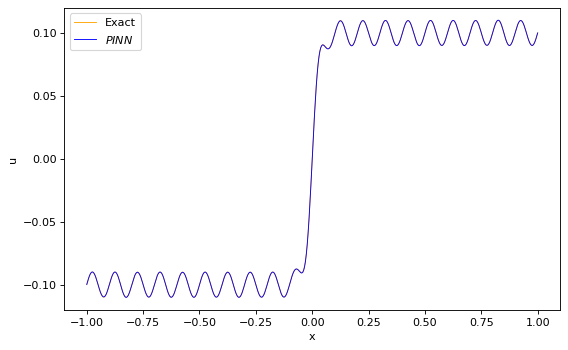

In [21]:
plt.figure(figsize=(8, 5), dpi=80)
x = np.concatenate([np.array([np.linspace(-1,1,500)]).T],axis=1)
X = torch.tensor(x, dtype=torch.float32, device=device)
plt.ylim(-0.12,0.12)
plt.plot(x,amp*(A*np.sin(omega*x)+np.tanh(beta*x)), label = 'Exact', color = 'orange')
plt.plot(x,net(X).T[0].cpu().detach().numpy(),label = '$PINN$', color='b')
Xp = np.linspace(-1,1,500)
plt.ylabel('u')
plt.xlabel('x')
#plt.title('Ground Truth')
plt.legend()
#plt.savefig(folder +'Weak_sob_S1_FF.png')